In [1]:
# https://www.ioiogoo.cn/2018/05/31/%e4%bd%bf%e7%94%a8k-means%e5%8f%8atf-idf%e7%ae%97%e6%b3%95%e5%af%b9%e4%b8%ad%e6%96%87%e6%96%87%e6%9c%ac%e8%81%9a%e7%b1%bb%e5%b9%b6%e5%8f%af%e8%a7%86%e5%8c%96/

In [2]:
# -*- coding: utf-8 -*-
# file: data_utils.py
# author: apollo2mars <apollo2mars@gmail.com>

import os
import pickle
import numpy as np


class Tokenizer(object):
	""" Tokenizer for Machine Reading Comprehension

	1. Input : max length of context
	2. Get vocabulary dict : self.word2idx and self.idx2word
	3. Get Embedding Matrix
		if embedding matrix exits, load from exit file
		else build new embedding matrix
	"""

	def __init__(self, origin_text, max_seq_len, emb_dim, lower, emb_type, dat_fname, fname):
		self.origin_text = origin_text
		self.max_seq_len = max_seq_len
		self.emb_dim = emb_dim
		self.lower = lower
		self.emb_type = emb_type
		self.path_1 = dat_fname
		self.path_2 = fname

		self.word2idx = {}
		self.idx2word = {}
		self.vocab_embed = []

		self.embedding_info = Tokenizer.__embedding_info()
		self.__load_embedding(word2idx=self.word2idx, emb_dim=self.emb_dim, dat_fname=self.path_1, fname=self.path_2)
		self.__set_vocabulary(self.origin_text)
		self.__encode_vocab()

	@staticmethod
	def __embedding_info():
		embedding_files = {
			'Static':{
				"Word2Vec":"",
				"Glove":"",
				"Tencent":""},
			'Dynamic':{
				"BERT":"",
				"ELMo":"",
				"ERINE":"",
				"GPT-2-Chinese":"",
				"BERT-WWW":""}
		}

		return embedding_files

	def __load_embedding(self, word2idx, emb_dim, dat_fname, fname):
		if os.path.exists(dat_fname):
			embedding_matrix = pickle.load(open(dat_fname, 'rb'))
		else:
			embedding_matrix = np.zeros((len(word2idx) + 2, emb_dim))  # idx 0 and len(word2idx)+1 are all-zeros
			word_vec = Tokenizer.__get_vocabulary_embedding_vector_list(fname, word2idx=word2idx)
			for word, i in word2idx.items():
				embedding_matrix[i] = word_vec[word]
			pickle.dump(embedding_matrix, open(dat_fname, 'wb'))

		self.embedding_matrix = embedding_matrix

	def __set_vocabulary(self, input_text):
		"""
		:param text: text for generate vocabulary
		:return: null
		"""
		if self.lower:
			tmp_text = input_text.lower()

		from collections import Counter
		count = Counter(tmp_text)

		for idx, item in enumerate(count):
			self.word2idx[item] = idx + 1  # must + 1
			self.idx2word[idx + 1] = item

	def __encode_vocab(self, input_path, word2idx=None):
		"""
		:param input_path: staic embedding file, for example("Glove.6b.300d")
				, [0.2,0.6,..,0.2]
				Apple [0.3,0.3,..,0.7]
				Bob [0.3,0.4,..,0.7]
				Car [0.5,0.4,..,0.7]
				Do [0.8,0.4,..,0.7]
				Eat [0.9,0.4,..,0.7]
				...
				Zip [0.3,0.6,..,0.7]
		:param word2idx: vocabulary for current task  [list]
				input file : Bob Eat Apple
				[Apple, Eat, Apple]
		:return: embedding vector list for vocabury
				[[0.3,0.4,..,0.7]
				[0.9,0.4,..,0.7]
				[0.3,0.3,..,0.7]]

		get embeddding vector list from embedding matrix by vovabulary

		"""
		fin = open(input_path, 'r', encoding='utf-8', newline='\n', errors='ignore')
		word_vec = {}
		for line in fin:
			tokens = line.rstrip().split(' ')
			if word2idx is None or tokens[0] in word2idx.keys():
				word_vec[tokens[0]] = np.asarray(tokens[1:], dtype='float32')

		self.vocab_embed = word_vec

	@classmethod
	def __pad_and_truncate(cls, sequence, maxlen, dtype='int64', padding='post', truncating='post', value=0):
		x = (np.ones(maxlen) * value).astype(dtype)

		if truncating == 'pre':
			trunc = sequence[-maxlen:]
		else:
			trunc = sequence[:maxlen]
			trunc = np.asarray(trunc, dtype=dtype)
		if padding == 'post':
			x[:len(trunc)] = trunc
		else:
			x[-len(trunc):] = trunc
		return x

	def encode(self, text, reverse=False, padding='post', truncating='post'):
		"""
		convert text to numberical gigital features with max length, paddding
		and truncating
		"""
		if self.lower:
			text = text.lower()
		words = list(text)
		unknown_idx = len(self.word2idx)+1
		sequence = [self.word2idx[w] if w in self.word2idx else unknown_idx for w in words]
		if len(sequence) == 0:
			sequence = [0]
		if reverse:
			sequence = sequence[::-1]

		return Tokenizer.__pad_and_truncate(sequence, self.max_seq_len, padding=padding, truncating=truncating)


In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# from data_utils import *
import jieba
import matplotlib.pyplot as plt

In [4]:
# bigram分词
# segment_bigram = lambda text: " ".join([word + text[idx + 1] for idx, word in enumerate(text) if idx &lt; len(text) - 1])
# 结巴中文分词
segment_jieba = lambda text: " ".join(jieba.cut(text))
 
'''
加载语料
'''
corpus = []
with open("demo_1.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        # print(">>>", line)
        tmp = segment_jieba(line)
        # print(tmp)
        corpus.append(tmp)
 

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/ph/31crq1pj14n9pcl2xffj45j8t0c5l2/T/jieba.cache
Loading model cost 0.792 seconds.
Prefix dict has been built succesfully.


In [5]:
# corpus = [
# ...     'This is the first document.',
# ...     'This is the second second document.',
# ...     'And the third one.',
# ...     'Is this the first document?',
# ... ]
# vectorizer = CountVectorizer()
# transformer = TfidfTransformer()
# X = vectorizer.fit_transform(corpus)

# print(vectorizer.get_feature_names())
# print(X)
# print(transformer.fit_transform(X))

In [6]:
'''
计算tf-idf设为权重
'''
vectorizer = CountVectorizer()
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorizer.fit_transform(corpus))
# print(tfidf[:50])

In [7]:
''' 
获取词袋模型中的所有词语特征
如果特征数量非常多的情况下可以按照权重降维
'''
word = vectorizer.get_feature_names()
print("word feature length: {}".format(len(word)))
print("word feature : {}".format(word[:50]))

word feature length: 438
word feature : ['100', '1000', '20ml', '800', '818', '90', '98', '99', 'bu', 'convenient', 'delivery', 'efficiency', 'friction', 'good', 'hellip', 'hhhhhhhhhhhhhhhhhhhhhhhh', 'on', 'time', '一个', '一个多月', '一分', '一千多块', '一次', '一百', '一百多块', '一遍', '七系', '丈人', '下巴', '不了', '不划算', '不太', '不少', '不怎么', '不敢', '不能', '不错', '两个', '两次', '两瓶', '两百多', '中国', '买个', '买来', '买过', '二手', '二手货', '二百多', '产地', '京东']


In [8]:
''' 
导出权重，到这边就实现了将文字向量化的过程，矩阵中的每一行就是一个文档的向量表示
'''
tfidf_weight = tfidf.toarray()

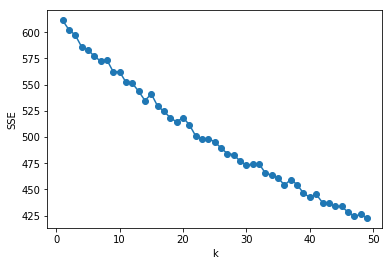

In [9]:
SSE = []  # 存放每次结果的误差平方和
for k in range(1,50):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(tfidf_weight)
    SSE.append(estimator.inertia_)
X = range(1,50)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')


In [13]:
# 聚类
import math
n_clusters=int(math.sqrt(len(corpus)/2))
print("n_clusters is ", n_clusters)
kmeans = KMeans(n_clusters)
kmeans.fit(tfidf_weight)

# 显示聚类结果
# print(kmeans.cluster_centers_)

result_dict = {}
print(len(kmeans.labels_))
print(len(corpus))
for index, label in enumerate(kmeans.labels_, 0):
#     print(" ======== new item =========")
#     print("index: {}, label: {}".format(corpus[index], label))
    if label in result_dict.keys():
        tmp_list = result_dict[label]
#         print(corpus[index])
        tmp_list.extend([corpus[index]])
#         print(">>> tmp_list", tmp_list)
        result_dict[label] = tmp_list
    else:
        result_dict[label] = [corpus[index]]

print(result_dict)
# print(result_dict[0])
# print(result_dict[1])
 
# 样本距其最近的聚类中心的平方距离之和，用来评判分类的准确度，值越小越好
# k-means的超参数n_clusters可以通过该值来评估
# print("inertia: {}".format(kmeans.inertia_))

# '''
# 可视化
# '''
# # 使用T-SNE算法，对权重进行降维，准确度比PCA算法高，但是耗时长
# tsne = TSNE(n_components=2) # 降低到2维度，方便显示
# decomposition_data = tsne.fit_transform(tfidf_weight)
 
# x = []
# y = []
 
# for i in decomposition_data:
#     x.append(i[0])
#     y.append(i[1])
 
# fig = plt.figure(figsize=(10, 10))
# ax = plt.axes()
# plt.scatter(x, y, c=kmeans.labels_, marker="x")
# plt.xticks(())
# plt.yticks(())
# # plt.show()
# plt.savefig('./sample.png', aspect=1)

n_clusters is  18
673
673
{5: ['商品 颜色', '商品 用途', '商品质量', '运转 音', '退货 服务', '客服 态度', '商品 产地', '商品 复购', '商品 外观', '商品价格', '商品 营销', '续航', '换货 服务', '价保', '客服 其他', '清洁 方式', '尺寸', '售后 其他', '显示', '> > > > > >', '商品 颜色', '颜色', '银色', '黑色', '石 蓝色', '银白色', '> > > > > >', '商品 用途', '送人 的', '送人', '给 老公 买 的', '买来 送人 的', '送人 的 礼物', '买 给 公公 的', '父亲节 礼物', '给 老爹 买 的', '送给 我 老公 的 生日礼物', '给 公司员工 买 的', '啦 啦 啦 啦 啦 啦 啦 啦 啦 啦 啦 啦 。', '给 父亲 准备 的 父亲节 礼物', '买 给 岳父 的', '帮 同事 买 的', '买来 送 岳父', '帮 家人 买 的', '送人 的 礼品', '送人用 的', '帮别人 买 的', '送人 3 个', '给 老公 的 礼物', '给 家人 买 的', '送 男人', '金敏 公民 咯咯 哦 咯咯 , ,', '哎哟 还 不错 哦哦哦 哦哦哦 哦哦哦 哦哦哦 哦哦哦', '礼物 送人 的', '给 室友 买 的', '送给 客户 的 礼物', '送给 老丈人', '送人 好看', '给 父亲 买 的', '给 父亲 买 的 父亲节 礼物', '给 老人 买 的', '送 完 丈人 送亲 爹', '给 爸 买 的', '给 老公 生日 买 的', '买 给 我 爸用 的', '过年 小 礼物', '买 给 老丈人 的', '京豆京 豆京 豆京豆京 豆京豆京 豆京豆京 豆京豆京 豆京豆京 豆京豆京 豆京豆京 豆京豆京 豆京豆京 豆京豆京 豆京豆京 豆京豆 , , ,', '给 老人 买 了', '送给 老公', '送 老爷子 的', '买 给 自己 家人 用 的', '不错 啦 咯 啦 咯 啦 咯 啦 咯 啦 咯 啦 咯 啦 咯 啦 咯 ,', '准备 送人', '买 给 我 爸 比 的', '送给 老公 的 生日礼物', '送 家人', '送给 父亲

In [11]:
a = [1, 2, 3, 4, 5]

for idx, value in enumerate(a):
    print("idx is {}, value is {}".format(idx, value))
    
for idx, value in enumerate(a, 1):
    print("idx is {}, value is {}".format(idx, value))

idx is 0, value is 1
idx is 1, value is 2
idx is 2, value is 3
idx is 3, value is 4
idx is 4, value is 5
idx is 1, value is 1
idx is 2, value is 2
idx is 3, value is 3
idx is 4, value is 4
idx is 5, value is 5
